# Multinomial Naive Bayes

Tenemos un archivo que tiene los datos ya curados de 5572 correos electronicos con el texto de esos correos y clasificados como SPAM o HAM (en la jerga de los correos electronicos son los correos deseados).

El objetivo de esta notebook es entrenar un modelo de aprendizaje automatico utilizando el algoritmo de Naive Bayes para clasificar futuros correos electronicos como 'HAM' o 'SPAM'.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

## Dataset
El archivo spam_or_ham.txt tiene que estar en la misma carpeta en donde se esta corriendo esta notebook. Caso contrario modificar la linea correspondiente en donde se carga el archivo y se lo almacena como una DF en la variable `dataset`

In [2]:
dataset = pd.read_table("spam_or_ham.txt", header=None, names=["target", "text"])
type(dataset), dataset.shape

(pandas.core.frame.DataFrame, (5572, 2))

In [3]:
dataset.head(5)

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
# cuantos correos tenemos de cada tipo?
(dataset
 .groupby('target')
 .count()
 )

,text
target,
ham,4825
spam,747


Vemos que nuestro dataset esta un poco desvalanceado. Hay muchos mas correos clasificados como HAM que como SPAM

In [5]:
# Visualizamos al azar un correo que haya sido clasificado como HAM y otro que haya sido clasificado como SPAM
print('ham:')
print(dataset.iloc[4,1])
print('spam:')
print(dataset.iloc[2,1])

ham:
Nah I don't think he goes to usf, he lives around here though
spam:
Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


## `CountVectorizer()`

Transform the input from text into a bag of words matrix ([documentation](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html)).

In [6]:
# 1. Instanciamos la clase CountVectorizer()
vectorizer = CountVectorizer()

# 2. Aplicamos el metodo fit_transform (learn the vocabulary dictionary and return document-term matrix).
vectorized_data = vectorizer.fit_transform(dataset.text)

In [7]:
# usamos el metodo get_feature_names_out() para ver una parte de la bolsa de palabras que obtuvimos.
# get_feature_names_out(): Get output feature names for transformation
vectorizer.get_feature_names_out()[4000:4100]

array(['huge', 'hugging', 'hugh', 'hugs', 'huh', 'hui', 'huiming', 'hum',
       'humanities', 'humans', 'hun', 'hundred', 'hundreds', 'hungover',
       'hungry', 'hunks', 'hunny', 'hunt', 'hunting', 'hurricanes',
       'hurried', 'hurry', 'hurt', 'hurting', 'hurts', 'husband',
       'hussey', 'hustle', 'hut', 'hv', 'hv9d', 'hvae', 'hw', 'hyde',
       'hype', 'hypertension', 'hypotheticalhuagauahahuagahyuhagga',
       'iam', 'ias', 'ibh', 'ibhltd', 'ibiza', 'ibm', 'ibn', 'ibored',
       'ibuprofens', 'ic', 'iccha', 'ice', 'icic', 'icicibank', 'icky',
       'icmb3cktz8r7', 'icon', 'id', 'idc', 'idea', 'ideal', 'ideas',
       'identification', 'identifier', 'idew', 'idiot', 'idk', 'idps',
       'idu', 'ie', 'if', 'iff', 'ifink', 'ig11', 'ignorant', 'ignore',
       'ignoring', 'ihave', 'ijust', 'ikea', 'ikno', 'iknow', 'il',
       'ileave', 'ill', 'illness', 'illspeak', 'ilol', 'im', 'image',
       'images', 'imagination', 'imagine', 'imat', 'imf', 'img', 'imin',
       'imma'

In [8]:
vectorized_data.shape, type(vectorized_data)

((5572, 8713), scipy.sparse.csr.csr_matrix)

- `vectorized_data` es la matriz (**sparsa**) que obtuvimos como producto de aplicar la clase `CountVectorizer()` a los datos de la columna `text` de nuestro dataset.
- Cada columna de esta matriz corresponde a una palabra encontrada en los correos electronicos.
- Las palabras estan ordenadas alfabeticamente
- Cada fila de la matriz corresponde a uno de los correos electronicos. Se mantiene el mismo indice que los correos tiene en la DF `dataset`
- Cada celda de la matriz contiene un numero entero que representa el numero de veces que esa palabra aparece en el mail correspondiente a esa fila. Si la palabra no esta en el mail, el valor es cero.

In [9]:
vectorized_data

<5572x8713 sparse matrix of type '<class 'numpy.int64'>'
	with 74169 stored elements in Compressed Sparse Row format>

Debido a que `vectorized_data` es una matriz esparsa, no podemos visualizarla en forma directa. Para poder hacerlo tenemos que utilizar el metodo `.to_array`

In [10]:
vectorized_data.toarray(), vectorized_data.toarray().shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64),
 (5572, 8713))

### Dividimos los datos en conjunto de entrenamiento y de prueba

In [11]:
X_train, X_test, y_train, y_test = train_test_split(vectorized_data, dataset.target, test_size = 0.2, random_state = 5)

In [12]:
X_train.shape, y_train.shape

((4457, 8713), (4457,))

In [13]:
X_test.shape, y_test.shape

((1115, 8713), (1115,))

## `MultinomialNB()`
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification).

In [14]:
# 1. Instanciamos la clase MultinominalNM, es decir, elegimos el modelo que luego vamos a entrenar
m_nb_clf = MultinomialNB() #dejamos los hiperparametros que vienen predeterminados

# 2. Entrenamos el modelo usando los datos de entrenamiento
m_nb_clf.fit(X_train, y_train)

MultinomialNB()

In [15]:
m_nb_clf.class_count_

array([3855.,  602.])

In [16]:
m_nb_clf.classes_

array(['ham', 'spam'], dtype='<U4')

Los resultados de las celdas anteriores indican que el modelo fue entrenado usando 3855 mails HAM y 602 mails SPAM. Nuevamente vemos que hay una diferencia importante en el numero de observaciones de cada clase. Esto podria traer algunos problemas para generalizar el uso de este modelo.

## Evaluacion del modelo `m_nb_clf`

Podemos ver algún caso en particular

Busquemos una entrada spam:

In [17]:
# analizamos al azar 20 observaciones del grupo de entrenamiento
y_train.sample(20, random_state = 0)

2961     ham
3028     ham
3593     ham
2532     ham
3943     ham
3111    spam
3272    spam
3742    spam
4281    spam
4296    spam
4335     ham
642      ham
714      ham
3568    spam
2868     ham
3223     ham
536      ham
1077     ham
1030     ham
2780     ham
Name: target, dtype: object

Primero comparemos a mano si nuestro clasificador está prediciendo correctamente ese dato del conjunto de entrenamiento

In [18]:
caso = 3272 #es un mail que fue etiquetado como spam

In [19]:
dataset.iloc[[caso]]

,target,text
3272,spam,You have 1 new voicemail. Please call 08719181...


In [20]:
m_nb_clf.predict(vectorized_data[caso])

array(['spam'], dtype='<U4')

El mail 3272 de la lista es clasificado por nuestro modelo `m_nb_clf` como spam. Coincide con la clasificacion original que tenia el mail, con los cual nuestro clasificador lo esta clasificando correctamente.

In [21]:
condition = m_nb_clf.predict(X_test) != y_test 
y_test_wrong_clf = y_test[condition]
y_test_wrong_clf

869     spam
4729     ham
2430    spam
2570     ham
2318     ham
1940    spam
4213    spam
2236     ham
1290     ham
2196     ham
228      ham
3132    spam
Name: target, dtype: object

In [22]:
print('e-mails that were not well classified by our model\n')
print('*'*50)

for i in y_test_wrong_clf.index:
    print(f'e-mail # {i}, Labeled as: {dataset.iloc[i].target}\t| Classified as: {m_nb_clf.predict(vectorized_data[i])[0]} ')
    proba = np.exp(m_nb_clf.predict_log_proba(vectorized_data[i]))
    print(f"Poba 'ham':{proba[0][0]}\t| Poba 'spam':{proba[0][1]}")
    print(dataset.iloc[i].text)
    print('-'*120 + '\n')


e-mails that were not well classified by our model

**************************************************
e-mail # 869, Labeled as: spam	| Classified as: ham 
Poba 'ham':0.9999879550279138	| Poba 'spam':1.2044972084231873e-05
Hello. We need some posh birds and chaps to user trial prods for champneys. Can i put you down? I need your address and dob asap. Ta r
------------------------------------------------------------------------------------------------------------------------

e-mail # 4729, Labeled as: ham	| Classified as: spam 
Poba 'ham':0.1663671224806417	| Poba 'spam':0.83363287751935
I (Career Tel) have added u as a contact on INDYAROCKS.COM to send FREE SMS. To remove from phonebook - sms NO to  &lt;#&gt;
------------------------------------------------------------------------------------------------------------------------

e-mail # 2430, Labeled as: spam	| Classified as: ham 
Poba 'ham':0.9723363000469025	| Poba 'spam':0.027663699953083324
Guess who am I?This is the first time I

Vemos que muchos de los correos que aparecen como mal clasificados era correos que tambien hubiera sido dificil clasificadar para una persona. Por lo tanto, si bien el modelo cometio algunos errores, no parece ser tan grave.

In [23]:
# una forma mas directa de ver si el caso esta bien clasificado
caso_n = 322 # se puede ir variando este numero para ver el cualquier caso deseado
m_nb_clf.predict(vectorized_data)[caso_n] == dataset.target[caso_n]

True

## `predict_log_proba()`
Podemos obtener la probabilidad de que haya sido spam o ham:

Esta funcion devuelve como resultado el logaritmo natural de la probabilidad, por lo tanto para obtener la probabilidad tenemos que transformarlo aplicando e**(predict_log_proba()) o lo que es igual np.exp(predict_log_proba())

In [24]:
np.exp(m_nb_clf.predict_log_proba(vectorized_data[caso]))

array([[0.01501237, 0.98498763]])

In [25]:
m_nb_clf.predict(vectorized_data)[caso_n]

'ham'

En este caso, la probabilidad de spam es mayor que la de ham. Veamos lo mismo pero para un caso que no era spam:

In [26]:
print(*dataset.iloc[5199])
print(np.exp(m_nb_clf.predict_log_proba(vectorized_data[5199])))

ham Ugh my leg hurts. Musta overdid it on mon.
[[9.99957311e-01 4.26892776e-05]]


En este caso la probabilidad de ham es mayor que la de spam, por eso lo clasifica como ham.

Veamos algunos casos del conjunto de prueba:

In [27]:
m_nb_clf.predict(X_test)[:20] == y_test[:20]

2095     True
5343     True
564      True
3849     True
3317     True
5277     True
1674     True
3753     True
5507     True
265      True
4413     True
5111     True
4896     True
3161     True
3743     True
2887     True
869     False
4061     True
1072     True
4559     True
Name: target, dtype: bool

## `classification_report()`

In [28]:

print(classification_report(y_test, m_nb_clf.predict(X_test)))

              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       970
        spam       0.95      0.97      0.96       145

    accuracy                           0.99      1115
   macro avg       0.97      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label a negative sample as positive.

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

The F-beta score can be interpreted as a weighted harmonic mean of the precision and recall, where an F-beta score reaches its best value at 1 and worst score at 0.

The F-beta score weights recall more than precision by a factor of beta. beta == 1.0 means recall and precision are equally important.

## `confusion_matrix()`

Usamos [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html):


In [29]:


y_test_pred = m_nb_clf.predict(X_test)

In [30]:
confusion_matrix = confusion_matrix(y_test, y_test_pred, labels=['ham', 'spam'])
confusion_matrix
# array = metrics.confusion_matrix(df_test["class"], predicted)

array([[963,   7],
       [  5, 140]], dtype=int64)

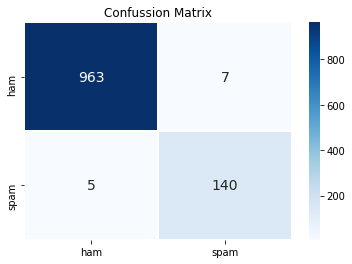

In [31]:
df_cm = pd.DataFrame(confusion_matrix, ["ham","spam"], 
["ham","spam"]) 

plt.figure()
# sns.set(font_scale=1.4)#for label size 
sns.heatmap(df_cm,
            cmap = 'Blues',
            annot=True,
            annot_kws={"size": 14},
            fmt='g',
            linecolor = 'white',
            linewidths = 0.5)
plt.title('Confussion Matrix')
plt.show()

Esta es otra forma de visualizar los resultados obtenidos al aplicar nuestro modelo a los datos de test:
- hay 7 e-mails que estaban etiquetados como ham que fueron clasiicados como spam
- hay 5 e-mails que estaban etiquetados como spam y fueron clasificados como ham